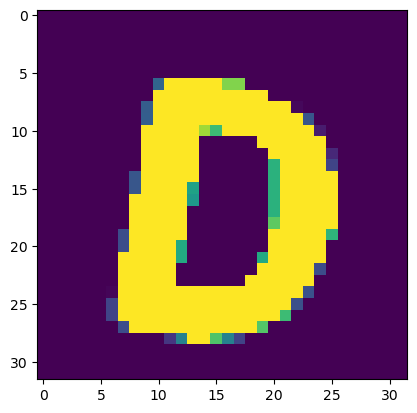

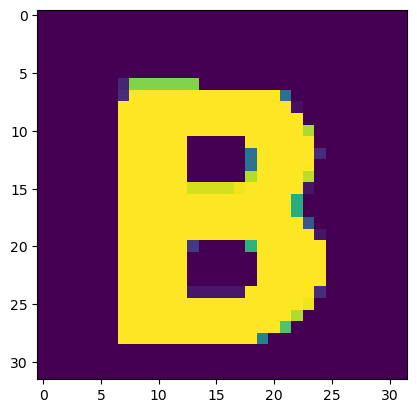

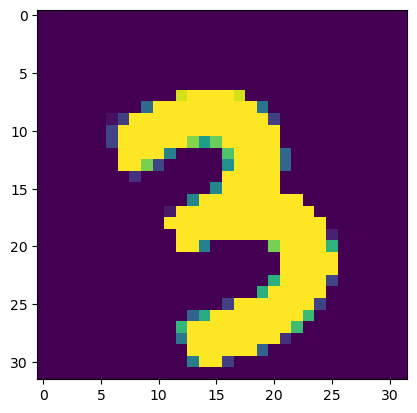

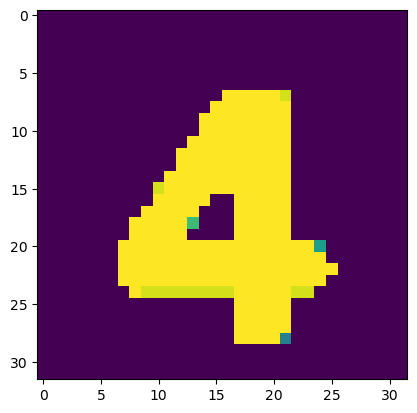

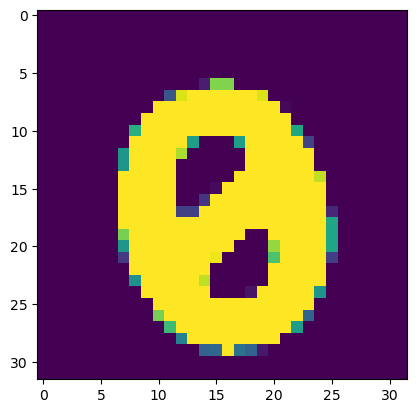

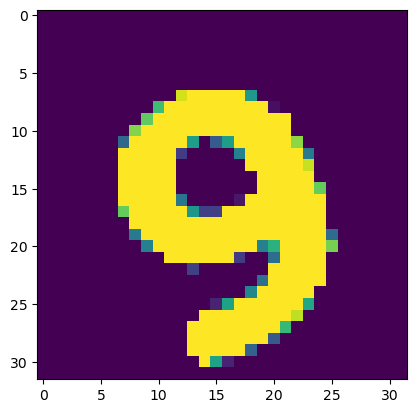

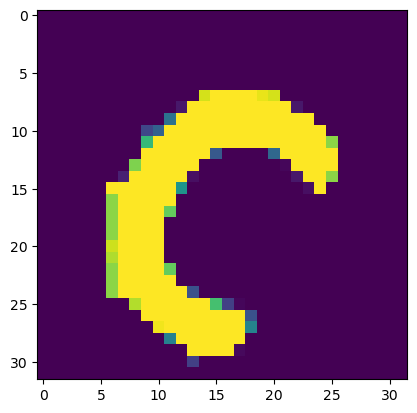

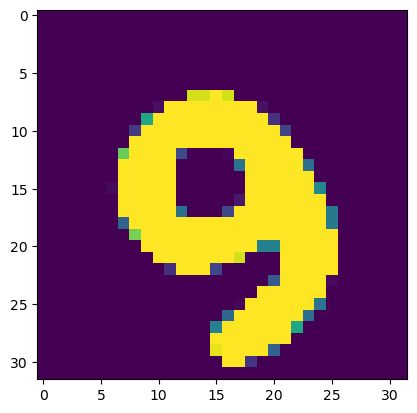

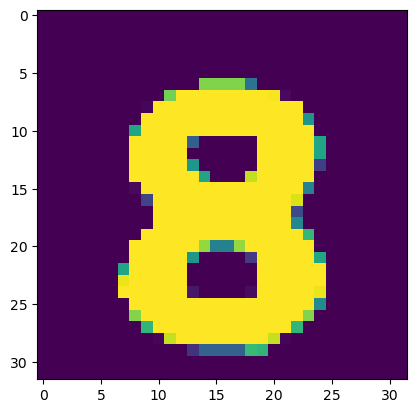

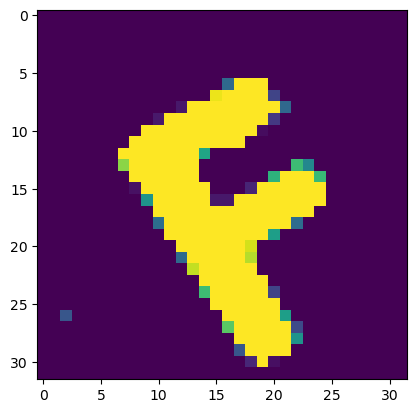

Training time : 1.9807147000683472


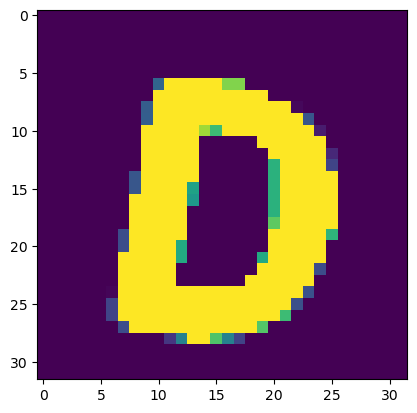

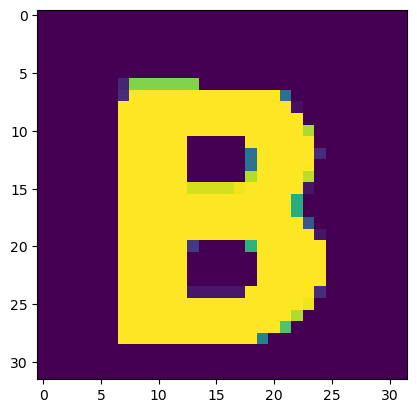

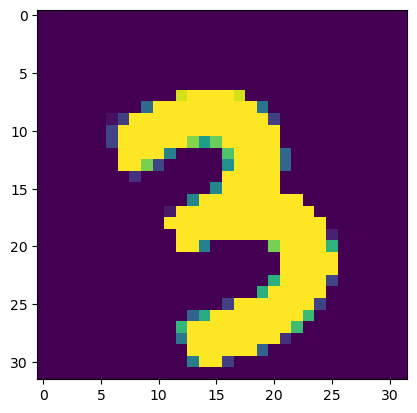

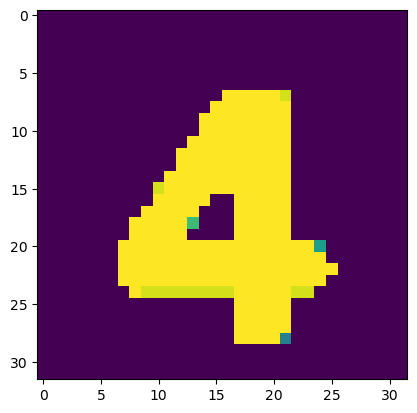

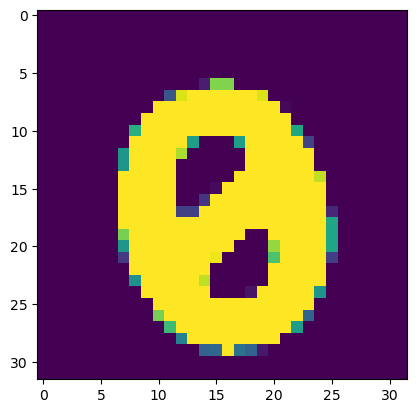

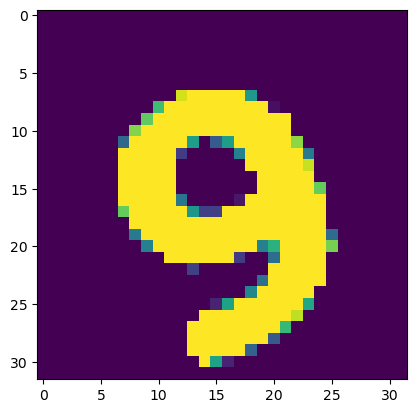

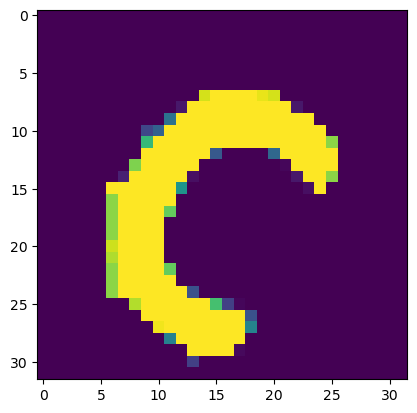

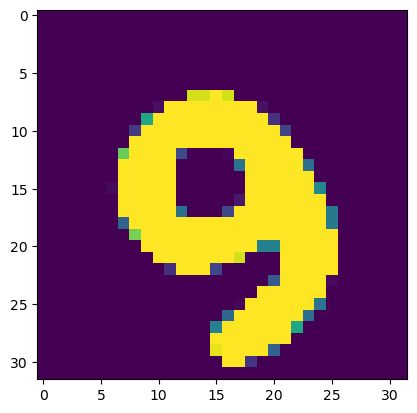

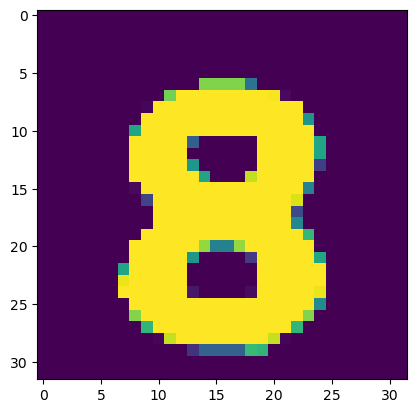

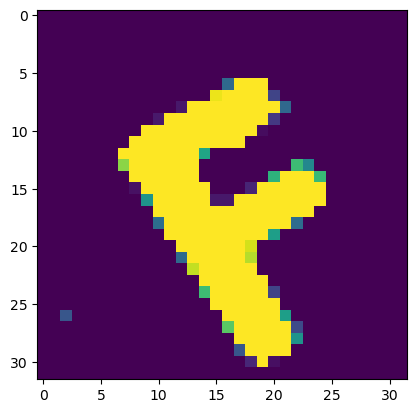

Testing time : 1.7633781000040472
1.0 1.0 1.0


In [1]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import cross_val_score
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time as tm

import os
import pickle


modelName = "model.pickle"
def decaptcha( filenames ):
    
    if not os.path.isfile(modelName):
        train()
        
    model = pickle.load(open(modelName, "rb"))
    
    tic = tm.perf_counter()
    processed_images = []
    
    for filename in filenames:
        img = cv2.imread(filename)
        processed_images.append(preprocess_image(img).flatten())
    
    labels = model.predict(processed_images)
    
    toc = tm.perf_counter()
    print(f"Testing time : {toc - tic}")

    return labels

def preprocess_image(img):
    h,w = img.shape[:2]
    
    # backgroung removal
    corners = [tuple(img[0,0]), tuple(img[0,w-1]), tuple(img[h-1,w-1]), tuple(img[h-1,0])]
    bg = max(set(corners), key=corners.count)

    #image masking
    fg_mask = np.logical_not(np.all(img==bg,-1))

    
    kernel = np.ones((5, 5), np.uint8)
    
    
    # Using cv2.erode() method 
    fg_mask = cv2.erode(fg_mask.astype(np.uint8), kernel)
    
    # Finding contours
    contours = cv2.findContours(fg_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]
    
    # Getting the last character
    c = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])[3]
    
    final_image = []
    
    
    left_x = max(np.amin(c[:,:,0]).item()-20, 0)
    right_x = min(np.amax(c[:,:,0]).item()+20, w)
    focused_img = np.clip(fg_mask[:,left_x:right_x].astype(np.float32)*255, 0,255)
    
    # Resizing image
    resized_image = cv2.resize(focused_img.astype(np.uint8),(32,32))
    
    # normalizing the image
    normalized_image = cv2.normalize(resized_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    final_image.append(normalized_image)
    
    plt.imshow(normalized_image)
    plt.show()
    
    # returning final pre-processed image
    return np.array(final_image)
  
    
def get_Image_From_Path(allImagePaths):
    X = []
    for imagesPath in allImagePaths:
        img = cv2.imread(imagesPath)
        X.append(preprocess_image(img).flatten())
    return X



def train():

    tic = tm.perf_counter()

    X_train = get_Image_From_Path(filepaths[:test_split])
    y_train = y[:test_split]

    model = LogisticRegression()

    model.fit(X_train, y_train)
    toc = tm.perf_counter()
    print(f"Training time : {toc - tic}")


    # save model
    pickle.dump(model, open(modelName, "wb"))


test_split = 10

filepaths = [ "train/%d.png" % i for i in range( 2000 ) ]
X_test = filepaths[:test_split]

y = np.loadtxt("train/labels.txt", dtype='str')    
y_test = y[:test_split]

    
# Predict labels for test images
y_pred = decaptcha(X_test)


precision = precision_score(y_test, y_pred, pos_label='ODD')
recall = recall_score(y_test, y_pred, pos_label='ODD')
f1 = f1_score(y_test, y_pred, pos_label='ODD')

print(precision,recall,f1)
